In [1]:
import os
import pandas as pd
import requests
import time
import json
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import seaborn as sns 

from sklearn.cross_decomposition import PLSRegression
from pygam import LinearGAM, s
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from statsmodels.stats.multitest import multipletests


In [2]:
data_folder = os.path.join(os.path.expanduser("~/Desktop/Trading"), "Data")
os.makedirs(data_folder, exist_ok=True)
tickers_csv_file = os.path.join(data_folder, "sp500_tickers.csv")



# THIS pulls sector and subsector info either localy if it's cached or from the api

API_KEY = "YwnbHRjcJvf6Md2OPoKbSRGHlzZ7hjR6"

# --- LOAD FROM CACHE OR FETCH ---
if os.path.exists(tickers_csv_file):
    print("Loading tickers from CSV cache...")
    df_sp500 = pd.read_csv(tickers_csv_file)
else:
    print("Fetching tickers from API...")
    url = f"https://financialmodelingprep.com/api/v3/sp500_constituent?apikey={API_KEY}"
    df_sp500 = pd.DataFrame(requests.get(url).json())

    # Save to CSV
    df_sp500.to_csv(tickers_csv_file, index=False)
    print(f"Saved {len(df_sp500)} tickers to CSV cache.")

    
# --- PREVIEW ---
print(df_sp500.shape)
print(df_sp500.columns)
print(df_sp500.head(5))

Loading tickers from CSV cache...
(503, 8)
Index(['symbol', 'name', 'sector', 'subSector', 'headQuarter',
       'dateFirstAdded', 'cik', 'founded'],
      dtype='object')
  symbol                  name                  sector  \
0    XYZ           Block, Inc.              Technology   
1    TTD  The Trade Desk, Inc.              Technology   
2   DDOG               Datadog              Technology   
3   COIN       Coinbase Global      Financial Services   
4   DASH              DoorDash  Communication Services   

                            subSector              headQuarter dateFirstAdded  \
0           Software - Infrastructure      Oakland, California     2025-07-23   
1              Software - Application      Ventura, California     2025-07-18   
2              Software - Application  New York City, New York     2025-07-09   
3  Financial - Data & Stock Exchanges     Wilmington, Delaware     2025-05-19   
4      Internet Content & Information        San Francisco, CA     2025-03

In [3]:
tickers = df_sp500["symbol"].dropna().unique().tolist()

In [4]:
# GETS THE PE DATA

API_KEY = "YwnbHRjcJvf6Md2OPoKbSRGHlzZ7hjR6"
data_folder = os.path.join(os.path.expanduser("~/Desktop/Trading"), "Data")
os.makedirs(data_folder, exist_ok=True)
tickers_csv_file = os.path.join(data_folder, "sp500_tickers.csv")

# Load tickers
df_sp500 = pd.read_csv(tickers_csv_file)
tickers = df_sp500["symbol"].dropna().unique().tolist()

# Output file
output_file = os.path.join(data_folder, "price_and_earnings.json")

def fetch_price_and_earnings(tickers, output_file):
    if os.path.exists(output_file):
        print(f"Loading from cache: {output_file}")
        return pd.DataFrame(json.load(open(output_file)))

    records = []
    for ticker in tickers:
        try:
            # Get current price
            quote_url = f"https://financialmodelingprep.com/api/v3/quote/{ticker}?apikey={API_KEY}"
            price_data = requests.get(quote_url).json()
            if not price_data:
                continue
            price = price_data[0]["price"]

            # Get latest annual income statement (EPS or netIncome)
            income_url = f"https://financialmodelingprep.com/api/v3/income-statement/{ticker}?limit=1&apikey={API_KEY}"
            income_data = requests.get(income_url).json()
            if not income_data:
                continue
            eps = income_data[0].get("eps")
            net_income = income_data[0].get("netIncome")

            records.append({
                "symbol": ticker,
                "price": price,
                "eps": eps,
                "netIncome": net_income
            })

        except Exception as e:
            print(f"Error fetching {ticker}: {e}")
        time.sleep(0.2)  # polite rate limit

    # Save to JSON
    with open(output_file, "w") as f:
        json.dump(records, f, indent=2)
    print(f"Saved {len(records)} records to {output_file}")

    return pd.DataFrame(records)

price_earnings_df = fetch_price_and_earnings(tickers, output_file)

Loading from cache: /Users/nicholassanso/Desktop/Trading/Data/price_and_earnings.json


In [22]:
#CLEANS AND TAKES LOG OF THE PE DATA

# Only keep rows with positive EPS
pe_data = price_earnings_df[price_earnings_df["eps"] > 0].copy()

# Compute log(PE)
pe_data["log_PE"] = np.log(pe_data["price"] / pe_data["eps"])

# Optional: store just the series if you want
pe_series = pe_data["log_PE"]

# Print row count for reference
print(f"Rows used: {len(pe_series)}")
print(pe_series.head())
print(pe_data.shape)

# we are only pulling the eps and takingthe log here.. the code that follows doesn't immediately and directly build on this code 

Rows used: 480
0    2.741115
1    4.033134
2    5.514162
3    3.434049
4    6.756855
Name: log_PE, dtype: float64
(480, 5)


## break 

In [6]:
# FETCHES INCOME STATEMENT AND BS STATEMENT AND CF STATEMENT
def fetch_statement(endpoint, tickers, period, limit, data_folder):
    """Fetch statements with unique JSON filename based on endpoint, period, limit."""
    output_file = os.path.join(
        data_folder,
        f"{endpoint}_{period}_limit{limit}.json"
    )

    if os.path.exists(output_file):
        print(f"Loading from cache: {output_file}")
        with open(output_file, "r") as f:
            return json.load(f)

    records = []
    for ticker in tickers:
        url = f"https://financialmodelingprep.com/api/v3/{endpoint}/{ticker}?period={period}&limit={limit}&apikey={API_KEY}"
        try:
            response = requests.get(url)
            response.raise_for_status()
            data = response.json()
            if data:
                for row in data:
                    row["symbol"] = ticker
                records.extend(data)
        except Exception as e:
            print(f"Error fetching {ticker} ({endpoint}): {e}")
        time.sleep(.2)  # API polite rate limit

    with open(output_file, "w") as f:
        json.dump(records, f, indent=2)
    print(f"Saved {len(records)} records to {output_file}")
    # "RECORDS HERE IS A LIST OF STRINGS NOT A DF"
    return records

# AT THIS POINT INCOME_DATA_2_YEARS IS STILL A LIST OF STRINGS STORED AS A VAR
income_data_2_years   = fetch_statement("income-statement", tickers, "annual", 2, data_folder)
balance_data_2_years  = fetch_statement("balance-sheet-statement", tickers, "annual", 2, data_folder)
cashflow_data_2_years = fetch_statement("cash-flow-statement", tickers, "annual", 2, data_folder)

# INCOME_DATA_2_YEARS IS CONVERTED TO A DF
income_data_2_years   = pd.DataFrame(income_data_2_years)
balance_data_2_years  = pd.DataFrame(balance_data_2_years)
cashflow_data_2_years = pd.DataFrame(cashflow_data_2_years)

print("Income shape:", income_data_2_years.shape)
print("Balance shape:", balance_data_2_years.shape)
print("Cash flow shape:", cashflow_data_2_years.shape)

print(income_data_2_years.columns)
print(balance_data_2_years.columns)
print(cashflow_data_2_years.columns)

Loading from cache: /Users/nicholassanso/Desktop/Trading/Data/income-statement_annual_limit2.json
Loading from cache: /Users/nicholassanso/Desktop/Trading/Data/balance-sheet-statement_annual_limit2.json
Loading from cache: /Users/nicholassanso/Desktop/Trading/Data/cash-flow-statement_annual_limit2.json
Income shape: (1006, 38)
Balance shape: (1006, 54)
Cash flow shape: (1006, 40)
Index(['date', 'symbol', 'reportedCurrency', 'cik', 'fillingDate',
       'acceptedDate', 'calendarYear', 'period', 'revenue', 'costOfRevenue',
       'grossProfit', 'grossProfitRatio', 'researchAndDevelopmentExpenses',
       'generalAndAdministrativeExpenses', 'sellingAndMarketingExpenses',
       'sellingGeneralAndAdministrativeExpenses', 'otherExpenses',
       'operatingExpenses', 'costAndExpenses', 'interestIncome',
       'interestExpense', 'depreciationAndAmortization', 'ebitda',
       'ebitdaratio', 'operatingIncome', 'operatingIncomeRatio',
       'totalOtherIncomeExpensesNet', 'incomeBeforeTax',
  

In [7]:
def sort_by_symbol_date(df):
    return df.sort_values(["symbol", "date"])


def compute_yoy_growth(df, exclude_cols=["symbol", "date","link","finalLink"]):
    numeric_cols = df.select_dtypes(include=[float, int]).columns
    numeric_cols = [c for c in numeric_cols if c not in exclude_cols]
    
    df_growth = df.copy()
    for col in numeric_cols:
        df_growth[col + "_yoy"] = df.groupby("symbol")[col].pct_change()
    
    return df_growth



income_sorted = sort_by_symbol_date(income_data_2_years)
balance_sorted = sort_by_symbol_date(balance_data_2_years)
cashflow_sorted = sort_by_symbol_date(cashflow_data_2_years)

income_growth = compute_yoy_growth(income_sorted)
balance_growth = compute_yoy_growth(balance_sorted)
cashflow_growth = compute_yoy_growth(cashflow_sorted)


#we are sorting to make sure that hte dates are properly aligned before we perform out pct chagne method 

In [8]:
def count_zeros_nans_yoy(df):
    # Keep only numeric columns that end with "_yoy"
    numeric_cols = [c for c in df.select_dtypes(include=[float, int]).columns if c.endswith("_yoy")]
    
    # Count zeros and NaNs
    zero_counts = (df[numeric_cols] == 0).sum()
    nan_counts = df[numeric_cols].isna().sum()
    
    # Combine into a single DataFrame
    summary = pd.DataFrame({
        "zeros": zero_counts,
        "nans": nan_counts
    }).sort_values(by=["zeros", "nans"], ascending=True)
    
    # Force full display
    with pd.option_context("display.max_rows", None, "display.max_columns", None):
        print(summary)
    
    return summary

# Example usage
print("Income 0/NaN counts per YoY column:")
income_summary = count_zeros_nans_yoy(income_growth)

print("\nBalance 0/NaN counts per YoY column:")
balance_summary = count_zeros_nans_yoy(balance_growth)

print("\nCashflow 0/NaN counts per YoY column:")
cashflow_summary = count_zeros_nans_yoy(cashflow_growth)

# the purpose here is to make it easy to identify which line items (columns) are fully filled out from our sample so that we are only grabbing columns (features)
# that are likely to be filled out by the stock under consideration, cause ultimately after we find a regression that has explanatory power... we can still only apply it 
# to the stock under consideration if it has the same line items filled out 
# the 503 nans is a result of the .pct change method that we used which creates a nan on every other row

Income 0/NaN counts per YoY column:
                                             zeros  nans
revenue_yoy                                      0   503
grossProfit_yoy                                  0   503
costAndExpenses_yoy                              0   503
ebitdaratio_yoy                                  0   503
operatingIncome_yoy                              0   503
operatingIncomeRatio_yoy                         0   503
incomeBeforeTax_yoy                              0   503
incomeBeforeTaxRatio_yoy                         0   503
netIncomeRatio_yoy                               0   503
ebitda_yoy                                       0   504
operatingExpenses_yoy                            0   507
costOfRevenue_yoy                                0   510
totalOtherIncomeExpensesNet_yoy                  0   535
generalAndAdministrativeExpenses_yoy             0   756
netIncome_yoy                                    1   503
eps_yoy                                          1  

In [9]:
def remove_single_period_features(df, nan_threshold=503, keep_cols=["symbol","date"], name=""):
    """Select _yoy numeric columns, replace inf, drop rows/columns with too many NaNs."""
    yoy_cols = [c for c in df.select_dtypes(include=[float, int]).columns if c.endswith("_yoy")]
    sub_df = df[yoy_cols + keep_cols].copy()  # Keep symbol/date columns
    
    # Drop columns with too many NaNs (only apply to yoy columns)
    valid_yoy_cols = [c for c in yoy_cols if sub_df[c].isna().sum() <= nan_threshold]
    sub_df = sub_df[valid_yoy_cols + keep_cols]
    
    # Replace infinities with NaN and drop rows with any remaining NaNs (only apply to yoy columns)
    sub_df[valid_yoy_cols] = sub_df[valid_yoy_cols].replace([np.inf, -np.inf], np.nan)
    sub_df.dropna(subset=valid_yoy_cols, inplace=True)
    
    print(f"{name} cleaned shape: {sub_df.shape}")
    return sub_df

# Step 0: Clean _yoy columns and print shapes
income_post_nans = remove_single_period_features(income_growth, name="Income")
balance_post_nans = remove_single_period_features(balance_growth, name="Balance")
cashflow_post_nans = remove_single_period_features(cashflow_growth, name="Cashflow")


Income cleaned shape: (502, 17)
Balance cleaned shape: (502, 12)
Cashflow cleaned shape: (501, 12)


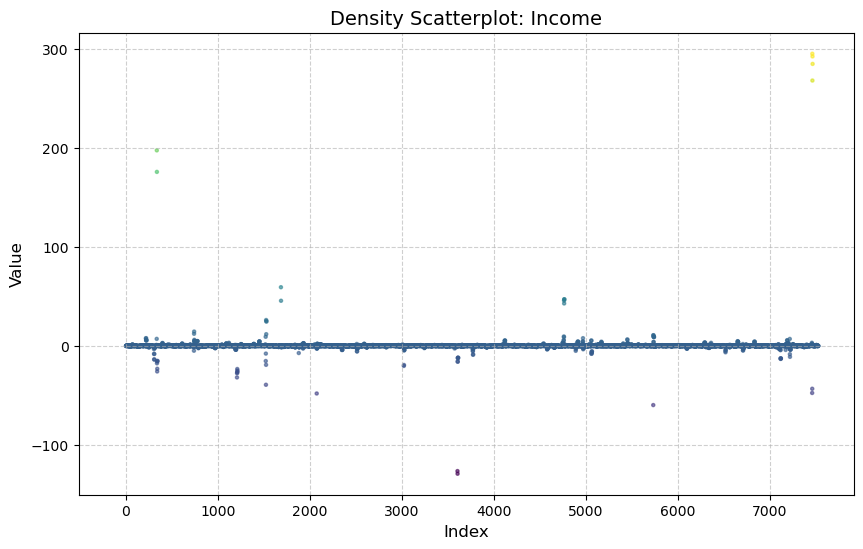

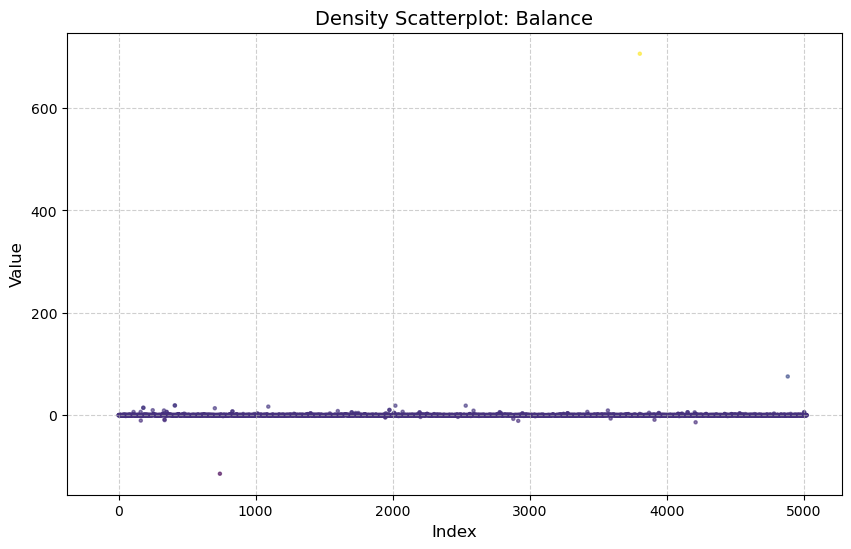

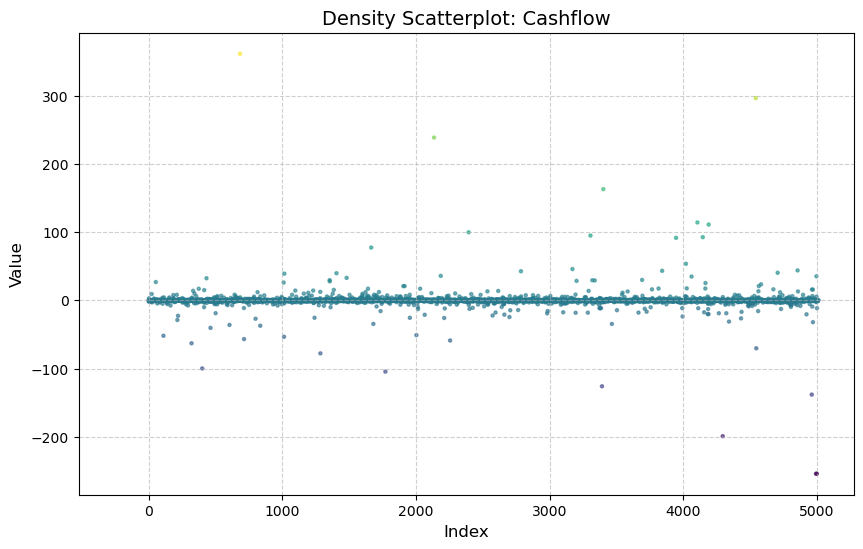

In [10]:
def plot_density_scatter(df, title):
    # Flatten all numeric columns into one long vector
    numeric_cols = df.select_dtypes(include=["float", "int"]).columns
    values = df[numeric_cols].values.flatten()
    values = values[~np.isnan(values)]  # drop NaNs

    # Scatter vs. index, colored by density
    plt.figure(figsize=(10, 6))
    sns.kdeplot(values, fill=True, color="lightblue", alpha=0.3, linewidth=0)  # background density
    plt.scatter(range(len(values)), values, 
                c=values, cmap="viridis", s=5, alpha=0.6)

    plt.title(f"Density Scatterplot: {title}", fontsize=14)
    plt.xlabel("Index", fontsize=12)
    plt.ylabel("Value", fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()

# Call for each of your cleaned DataFrames
plot_density_scatter(income_post_nans, "Income")
plot_density_scatter(balance_post_nans, "Balance")
plot_density_scatter(cashflow_post_nans, "Cashflow")

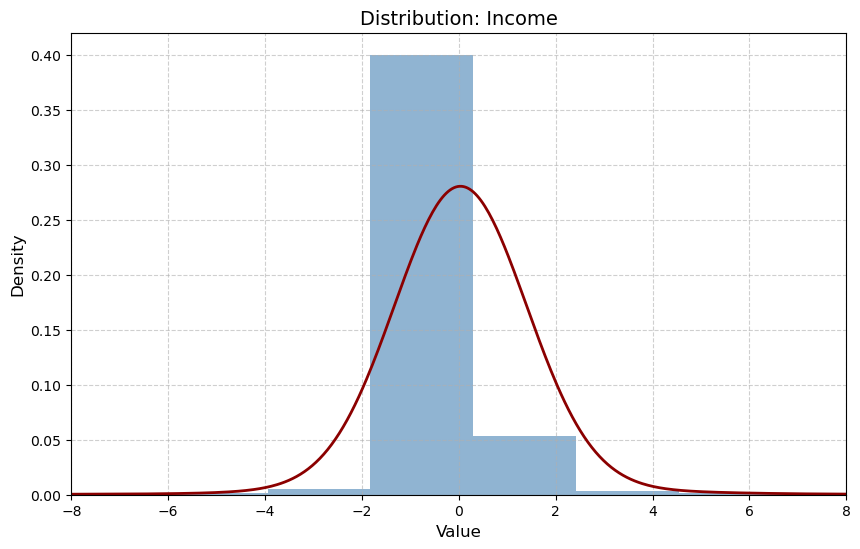

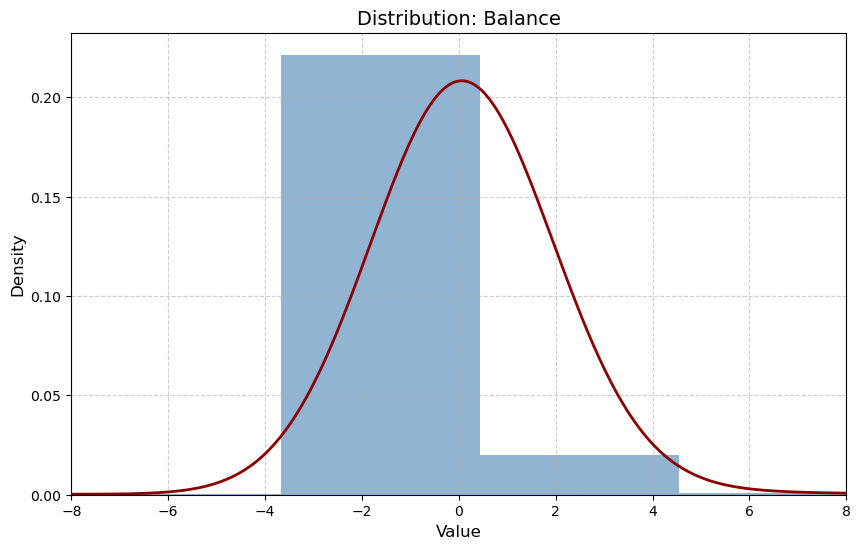

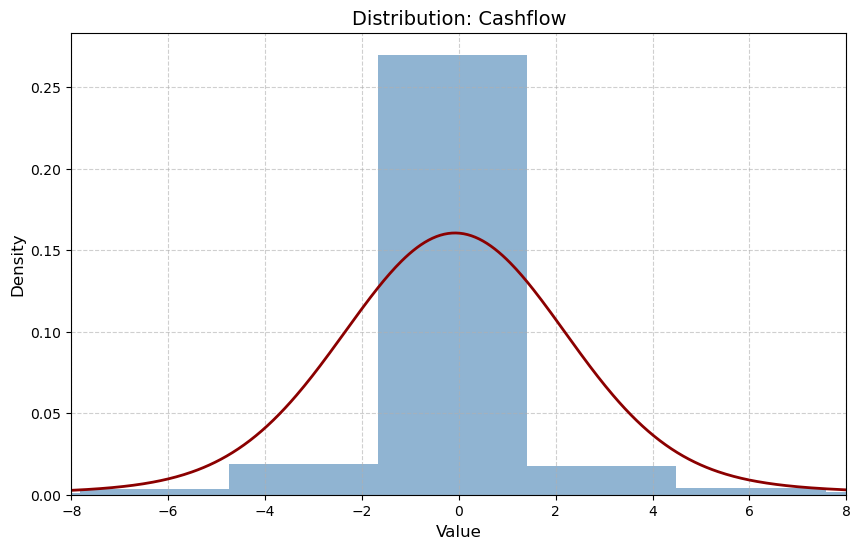

In [11]:
def plot_distribution(df, title):
    # Flatten numeric columns into one vector
    numeric_cols = df.select_dtypes(include=["float", "int"]).columns
    values = df[numeric_cols].values.flatten()
    values = values[~np.isnan(values)]  # remove NaNs

    plt.figure(figsize=(10, 6))
    plt.hist(values, bins=200, density=True, alpha=0.6, color="steelblue")
    
    # KDE overlay
    from scipy.stats import gaussian_kde
    kde = gaussian_kde(values)
    xs = np.linspace(-8, 8, 400)
    plt.plot(xs, kde(xs), color="darkred", lw=2)

    plt.title(f"Distribution: {title}", fontsize=14)
    plt.xlabel("Value", fontsize=12)
    plt.ylabel("Density", fontsize=12)
    plt.xlim(-8, 8)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()

# Call for each dataset
plot_distribution(income_post_nans, "Income")
plot_distribution(balance_post_nans, "Balance")
plot_distribution(cashflow_post_nans, "Cashflow")


In [12]:
# Step 1: Keep only common (symbol, date) pairs
for df in [income_post_nans, balance_post_nans, cashflow_post_nans]:
    df["symbol_date"] = list(zip(df["symbol"], df["date"]))

In [13]:
common_pairs = (
    set(income_post_nans["symbol_date"])
    & set(balance_post_nans["symbol_date"])
    & set(cashflow_post_nans["symbol_date"])
)

def filter_by_common_pairs(df, common_pairs):
    """
    Keep only rows where the 'symbol_date' is in common_pairs.
    Returns a new DataFrame.
    """
    return df[df["symbol_date"].isin(common_pairs)].copy()

income_post_nans_overlapped = filter_by_common_pairs(income_post_nans, common_pairs)
balance_post_nans_overlapped = filter_by_common_pairs(balance_post_nans, common_pairs)
cashflow_post_nans_overlapped = filter_by_common_pairs(cashflow_post_nans, common_pairs)

# we only want to include a ticker if we have all the financial statement items for all three financial statements 

In [14]:
# Step 2: Sort consistently
income_post_nans_overlapped = income_post_nans_overlapped.sort_values(["symbol", "date"]).reset_index(drop=True)
balance_post_nans_overlapped = balance_post_nans_overlapped.sort_values(["symbol", "date"]).reset_index(drop=True)
cashflow_post_nans_overlapped = cashflow_post_nans_overlapped.sort_values(["symbol", "date"]).reset_index(drop=True)

print(
    "Cleaned and aligned shapes:", 
    income_post_nans_overlapped.shape, 
    
    
    balance_post_nans_overlapped.shape, 
    cashflow_post_nans_overlapped.shape
)

Cleaned and aligned shapes: (491, 18) (491, 13) (491, 13)


In [15]:
print(income_post_nans_overlapped.shape)
print(balance_post_nans_overlapped.shape)
print(cashflow_post_nans_overlapped.shape)

print(income_post_nans_overlapped.columns)
print(balance_post_nans_overlapped.columns)
print(cashflow_post_nans_overlapped.columns)

(491, 18)
(491, 13)
(491, 13)
Index(['revenue_yoy', 'grossProfit_yoy', 'grossProfitRatio_yoy',
       'costAndExpenses_yoy', 'ebitdaratio_yoy', 'operatingIncome_yoy',
       'operatingIncomeRatio_yoy', 'incomeBeforeTax_yoy',
       'incomeBeforeTaxRatio_yoy', 'netIncome_yoy', 'netIncomeRatio_yoy',
       'eps_yoy', 'epsdiluted_yoy', 'weightedAverageShsOut_yoy',
       'weightedAverageShsOutDil_yoy', 'symbol', 'date', 'symbol_date'],
      dtype='object')
Index(['cashAndCashEquivalents_yoy', 'cashAndShortTermInvestments_yoy',
       'otherNonCurrentAssets_yoy', 'totalAssets_yoy', 'totalLiabilities_yoy',
       'totalStockholdersEquity_yoy', 'totalEquity_yoy',
       'totalLiabilitiesAndStockholdersEquity_yoy',
       'totalLiabilitiesAndTotalEquity_yoy', 'netDebt_yoy', 'symbol', 'date',
       'symbol_date'],
      dtype='object')
Index(['netIncome_yoy', 'changeInWorkingCapital_yoy',
       'netCashProvidedByOperatingActivities_yoy',
       'netCashUsedForInvestingActivites_yoy',
      

In [16]:
for name, df in {"income": income_post_nans_overlapped, "balance": balance_post_nans_overlapped, "cashflow": cashflow_post_nans_overlapped}.items():
    print(f"\n{name.upper()} FIRST 5 SYMBOLS:")
    print(df["symbol"].head(5).to_list())
    print(f"\n{name.upper()} LAST 5 SYMBOLS:")
    print(df["symbol"].tail(5).to_list())
    
    
# just a check that the symbols are the same and aligned 


INCOME FIRST 5 SYMBOLS:
['AAPL', 'ABBV', 'ABNB', 'ABT', 'ACGL']

INCOME LAST 5 SYMBOLS:
['XYZ', 'YUM', 'ZBH', 'ZBRA', 'ZTS']

BALANCE FIRST 5 SYMBOLS:
['AAPL', 'ABBV', 'ABNB', 'ABT', 'ACGL']

BALANCE LAST 5 SYMBOLS:
['XYZ', 'YUM', 'ZBH', 'ZBRA', 'ZTS']

CASHFLOW FIRST 5 SYMBOLS:
['AAPL', 'ABBV', 'ABNB', 'ABT', 'ACGL']

CASHFLOW LAST 5 SYMBOLS:
['XYZ', 'YUM', 'ZBH', 'ZBRA', 'ZTS']


In [24]:
def run_univariate_regressions(X, y):
    """
    Runs univariate OLS regressions of y on each column of X.
    
    Returns a DataFrame with coefficients, raw p-values, and FDR-adjusted p-values.
    """
    results = []

    for col in X.columns:
        X_const = sm.add_constant(X[[col]])
        model = sm.OLS(y, X_const).fit()
        coef = model.params[col]
        pval = model.pvalues[col]
        r2 = model.rsquared
        results.append((col, coef, pval, r2))

    results_df = pd.DataFrame(results, columns=["feature", "coef", "pval", "r2"])

    # Apply Benjamini-Hochberg FDR correction
    reject, pvals_corrected, _, _ = multipletests(results_df["pval"], 
                                                 alpha=0.05, method="fdr_bh")
    results_df["pval_fdr"] = pvals_corrected
    results_df["reject_null"] = reject

    return results_df


In [28]:
pe_data.shape

(480, 5)

In [29]:
# 1. Prepare the dependent variable with symbol/date
log_pe_df = pe_data[["symbol", "date", "log_PE"]].copy()

# 2. Merge income with log_pe
income_merged = income_post_nans_overlapped.merge(
    log_pe_df, on=["symbol", "date"], how="inner"
)
X_income = income_merged.select_dtypes(include=["number"]).drop(columns=["log_PE"])
y_income = income_merged["log_PE"]

income_uni = run_univariate_regressions(X_income, y_income)
print("Income statement results:")
print(income_uni.head())

# 3. Merge balance with log_pe
balance_merged = balance_post_nans_overlapped.merge(
    log_pe_df, on=["symbol", "date"], how="inner"
)
X_balance = balance_merged.select_dtypes(include=["number"]).drop(columns=["log_PE"])
y_balance = balance_merged["log_PE"]

balance_uni = run_univariate_regressions(X_balance, y_balance)
print("\nBalance sheet results:")
print(balance_uni.head())

# 4. Merge cashflow with log_pe
cashflow_merged = cashflow_post_nans_overlapped.merge(
    log_pe_df, on=["symbol", "date"], how="inner"
)
X_cashflow = cashflow_merged.select_dtypes(include=["number"]).drop(columns=["log_PE"])
y_cashflow = cashflow_merged["log_PE"]

cashflow_uni = run_univariate_regressions(X_cashflow, y_cashflow)
print("\nCashflow statement results:")
print(cashflow_uni.head())


KeyError: "['date'] not in index"

In [17]:
def run_pca_with_prefix(df, n_components=None, prefix="", columns=None, verbose=True):
    """
    Run PCA on a DataFrame with optional column selection, and print details.

    Parameters
    ----------
    df : pd.DataFrame
        Input data.
    n_components : int or None
        Number of PCA components. If None, use all available features.
    prefix : str
        Prefix for the PCA component column names.
    columns : list of str or None
        Subset of columns to run PCA on. If None, use all numeric columns
        except common ID columns like symbol/date.
    verbose : bool
        Whether to print debug information.

    Returns
    -------
    pd.DataFrame
        DataFrame with PCA component columns added.
    PCA
        The fitted PCA object.
    """

    # Drop common ID columns if present
    exclude_cols = ["symbol", "date", "symbol_date"]

    if columns is None:
        feature_df = df.drop(columns=[c for c in exclude_cols if c in df.columns], errors="ignore")
    else:
        feature_df = df[columns]

    # Make sure it's numeric
    feature_df = feature_df.select_dtypes(include="number")

    # Handle n_components safely
    max_components = min(feature_df.shape[0], feature_df.shape[1])
    if n_components is None:
        n_components = max_components
    else:
        n_components = min(n_components, max_components)

    # Standardize
    scaler = StandardScaler()
    scaled = scaler.fit_transform(feature_df)

    # PCA
    pca = PCA(n_components=n_components)
    components = pca.fit_transform(scaled)

    comp_df = pd.DataFrame(
        components,
        columns=[f"{prefix}{i+1}" for i in range(components.shape[1])],
        index=df.index
    )

    result = pd.concat([df, comp_df], axis=1)

    if verbose:
        print("=== PCA Run Summary ===")
        print(f"Prefix: {prefix}")
        print(f"Columns used: {list(feature_df.columns)}")
        print(f"Requested components: {n_components}")
        print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
        print("=======================")

    return result, pca


In [19]:
# Income statement PCA
income_df_with_pca, income_pca_model = run_pca_with_prefix(
    income_post_nans_overlapped.drop(columns=["symbol", "date", "symbol_date"], errors="ignore"),
    n_components=3,
    prefix="income_"
)

# Balance sheet PCA
balance_df_with_pca, balance_pca_model = run_pca_with_prefix(
    balance_post_nans_overlapped.drop(columns=["symbol", "date", "symbol_date"], errors="ignore"),
    n_components=3,
    prefix="balance_"
)

# Cash flow PCA
cashflow_df_with_pca, cashflow_pca_model = run_pca_with_prefix(
    cashflow_post_nans_overlapped.drop(columns=["symbol", "date", "symbol_date"], errors="ignore"),
    n_components=3,
    prefix="cashflow_"
)


=== PCA Run Summary ===
Prefix: income_
Columns used: ['revenue_yoy', 'grossProfit_yoy', 'grossProfitRatio_yoy', 'costAndExpenses_yoy', 'ebitdaratio_yoy', 'operatingIncome_yoy', 'operatingIncomeRatio_yoy', 'incomeBeforeTax_yoy', 'incomeBeforeTaxRatio_yoy', 'netIncome_yoy', 'netIncomeRatio_yoy', 'eps_yoy', 'epsdiluted_yoy', 'weightedAverageShsOut_yoy', 'weightedAverageShsOutDil_yoy']
Requested components: 3
Explained variance ratio: [0.31889143 0.16759947 0.14028581]
=== PCA Run Summary ===
Prefix: balance_
Columns used: ['cashAndCashEquivalents_yoy', 'cashAndShortTermInvestments_yoy', 'otherNonCurrentAssets_yoy', 'totalAssets_yoy', 'totalLiabilities_yoy', 'totalStockholdersEquity_yoy', 'totalEquity_yoy', 'totalLiabilitiesAndStockholdersEquity_yoy', 'totalLiabilitiesAndTotalEquity_yoy', 'netDebt_yoy']
Requested components: 3
Explained variance ratio: [0.39786858 0.17118367 0.13590006]
=== PCA Run Summary ===
Prefix: cashflow_
Columns used: ['netIncome_yoy', 'changeInWorkingCapital_yoy',

In [20]:
def regress_log_pe_on_pca(pca_df, log_pe_df, prefix="income_"):
    """
    Merge PCA outputs with log(PE) and run regression.
    
    Parameters
    ----------
    pca_df : pd.DataFrame
        DataFrame with PCA components (from run_pca_with_prefix).
    log_pe_df : pd.DataFrame
        DataFrame containing ['symbol','date','log_pe'] at least.
    prefix : str
        Prefix used in PCA component names (e.g., 'income_', 'balance_', 'cashflow_').

    Returns
    -------
    statsmodels RegressionResults
        The fitted regression model.
    """

    # 2. Select PCA columns
    X = merged[[c for c in merged.columns if c.startswith(prefix)]]
    y = merged["log_pe"]

    # 3. Add intercept
    X = sm.add_constant(X)

    # 4. Run regression
    model = sm.OLS(y, X).fit()

    print(model.summary())
    return model


In [21]:
# Suppose your PCA DataFrame already has components like income_1, income_2, income_3
income_model = regress_log_pe_on_pca(income_pcs, pe_data["log_PE"], prefix="income_")

# For balance sheet
balance_model = regress_log_pe_on_pca(balance_pcs, pe_data["log_PE"], prefix="balance_")

# For cash flow
cashflow_model = regress_log_pe_on_pca(cashflow_pcs, pe_data["log_PE"], prefix="cashflow_")


NameError: name 'income_pcs' is not defined